# Regresja liniowa: nadmierne dopasowanie i regularyzacja

W tym zadaniu zobaczymy, jak modele liniowe przetrenowują się, zrozumiemy, dlaczego tak się dzieje i dowiemy się, jak diagnozować i kontrolować przetrenowanie.

We wszystkich komórkach, w których znajduje się komentarz z instrukcjami, należy napisać kod wykonujący te instrukcje. Pozostałe komórki z kodem (bez komentarzy) należy po prostu wykonać. Ponadto zadanie wymaga udzielenia odpowiedzi na pytania; odpowiedzi należy wpisać po wyróżnionym słowie "__Answer:__".

In [523]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LassoCV
%matplotlib inline

Będziemy pracować ze zbiorem danych "bikes_rent.csv", który zawiera informacje kalendarzowe i warunki pogodowe, które charakteryzują zautomatyzowane punkty wypożyczania rowerów, a także liczbę wypożyczeń w danym dniu. Te ostatnie będziemy przewidywać; w ten sposób rozwiążemy problem regresji.

## Zapoznanie się z danymi

## Zadanie 1

Załaduj zestaw danych za pomocą funkcji __pandas.read_csv__ do zmiennej __df__. Wydrukuj pierwsze 5 wierszy, aby upewnić się, że dane zostały poprawnie odczytane:

In [524]:
df = pd.read_csv('bikes_rent.csv')
print(df.head())

   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Dla każdego dnia roboczego znane są następujące atrybuty:
* _season_: 1 - wiosna, 2 - lato, 3 - jesień, 4 - zima.
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: od 1 do 12.
* _holiday_: 0 - brak wakacji, 1 - wakacje.
* _weekday_: 0 do 6
* _workingday_: 0 oznacza dzień wolny od pracy, 1 oznacza dzień roboczy.
* _weathersit_: ocena korzystnej pogody od 1 (czysty, pogodny dzień) do 4 (ulewny deszcz, mgła)
* _temp_: temperatura w stopniach Celsjusza.
* _atemp_: temperatura w stopniach Celsjusza.
* _hum_: wilgotność
* _windspeed(mph)_: prędkość wiatru w milach na godzinę.
* _windspeed(ms)_: prędkość wiatru w metrach na sekundę.
* _cnt_: liczba wypożyczonych rowerów (jest to atrybut docelowy, będziemy go przewidywać).

Mamy więc cechy rzeczywiste, binarne i nominalne (porządkowe), a wszystkie z nich można traktować jako cechy rzeczywiste. Atrybuty nominalne mogą być również traktowane jako rzeczywiste, ponieważ mają porządek. Zobaczmy na wykresach, jak cecha docelowa zależy od innych cech

Wykres zależności atrybutów od liczby przejazdów. Innymi słowy, należy zbudować 12 wykresów. Każdy z nich powinien pokazywać zależność kolejnego atrybutu od zmiennej **cnt**.

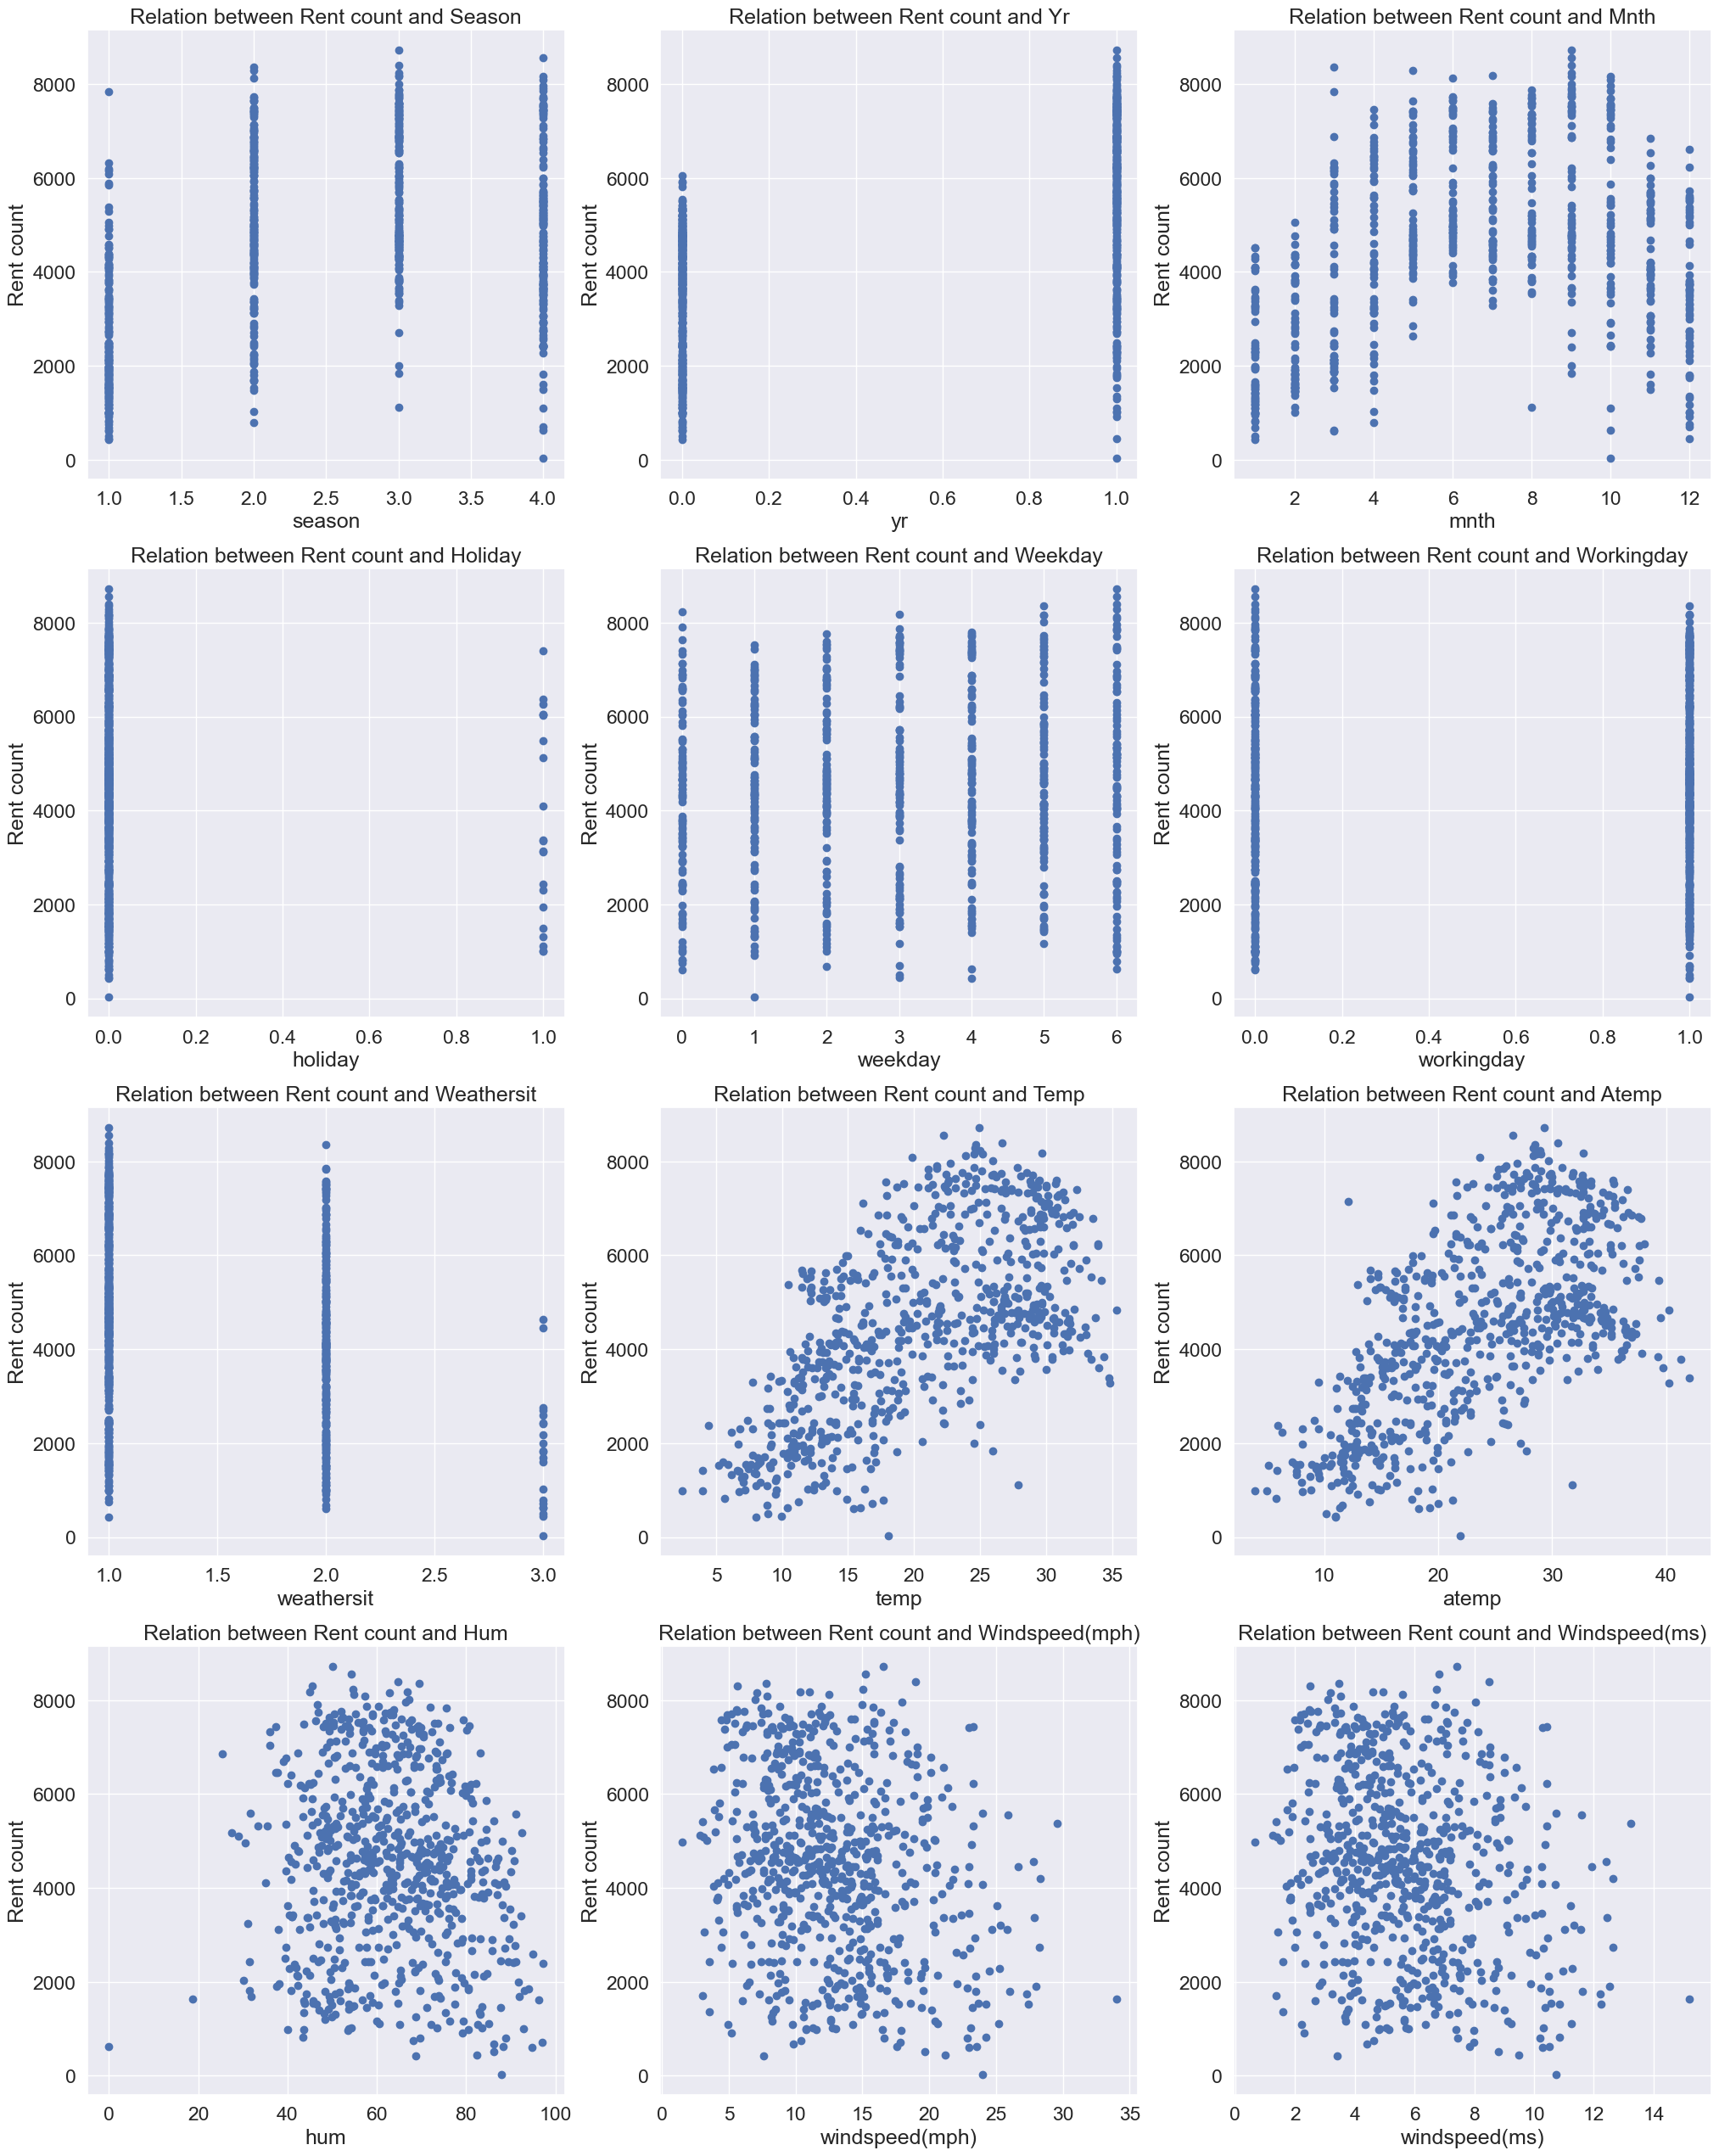

In [525]:
columns = df.columns[:-1]
x_columns = df[columns]
y_column = df[['cnt']]

n_rows = 4
n_cols = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize = (20, 25))
fig.tight_layout(pad=0.5)
fig.subplots_adjust(hspace=0.2, wspace=0.2)

for i, column  in enumerate(columns):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].scatter(df[column], df['cnt'])
    axes[row, col].set_title(f'Relation between Rent count and {column.capitalize()}')
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Rent count')
    axes[row, col].grid(True)

plt.show()

__Pytania:__
1. Jaka jest natura zależności liczby wypożyczeń od miesiąca?
1. Podaj jedną lub dwie cechy, od których liczba wypożyczeń najprawdopodobniej zależy liniowo

In [526]:
# 1. Paraboliczny.
# 2. Zaleznosc miedzy iloscia wypozyczen i temperatura jest liniowa.

## Zadanie 2

Bardziej rygorystycznie oceńmy poziom zależności liniowej między cechami a zmienną docelową. Dobrą miarą zależności liniowej między dwoma wektorami jest korelacja Pearsona. Mieliśmy już z nią do czynienia wcześniej. Aby ją obliczyć w pandach, możemy skorzystać z metod dataframe: corr i corrwith.

Oblicz korelacje wszystkich cech oprócz ostatniej z ostatnią cechą za pomocą metody `corrwith`.

Matrix correlation:
                  season        yr      mnth   holiday   weekday  workingday  \
season          1.000000 -0.001844  0.831440 -0.010537 -0.003080    0.012485   
yr             -0.001844  1.000000 -0.001792  0.007954 -0.005461   -0.002013   
mnth            0.831440 -0.001792  1.000000  0.019191  0.009509   -0.005901   
holiday        -0.010537  0.007954  0.019191  1.000000 -0.101960   -0.253023   
weekday        -0.003080 -0.005461  0.009509 -0.101960  1.000000    0.035790   
workingday      0.012485 -0.002013 -0.005901 -0.253023  0.035790    1.000000   
weathersit      0.019211 -0.048727  0.043528 -0.034627  0.031087    0.061200   
temp            0.334315  0.047604  0.220205 -0.028556 -0.000170    0.052660   
atemp           0.342876  0.046106  0.227459 -0.032507 -0.007537    0.052182   
hum             0.205445 -0.110651  0.222204 -0.015937 -0.052232    0.024327   
windspeed(mph) -0.229046 -0.011817 -0.207502  0.006292  0.014282   -0.018796   
windspeed(ms)  -0.22

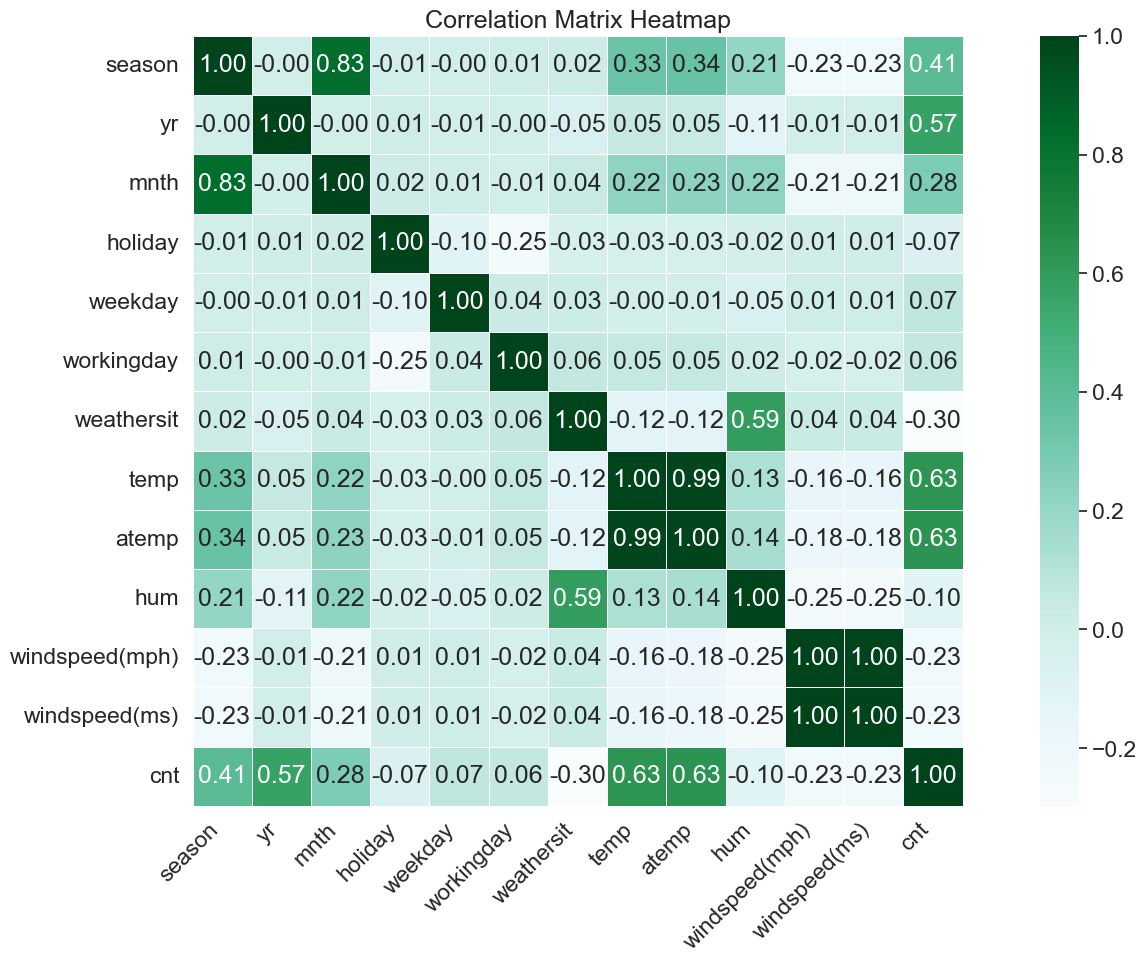

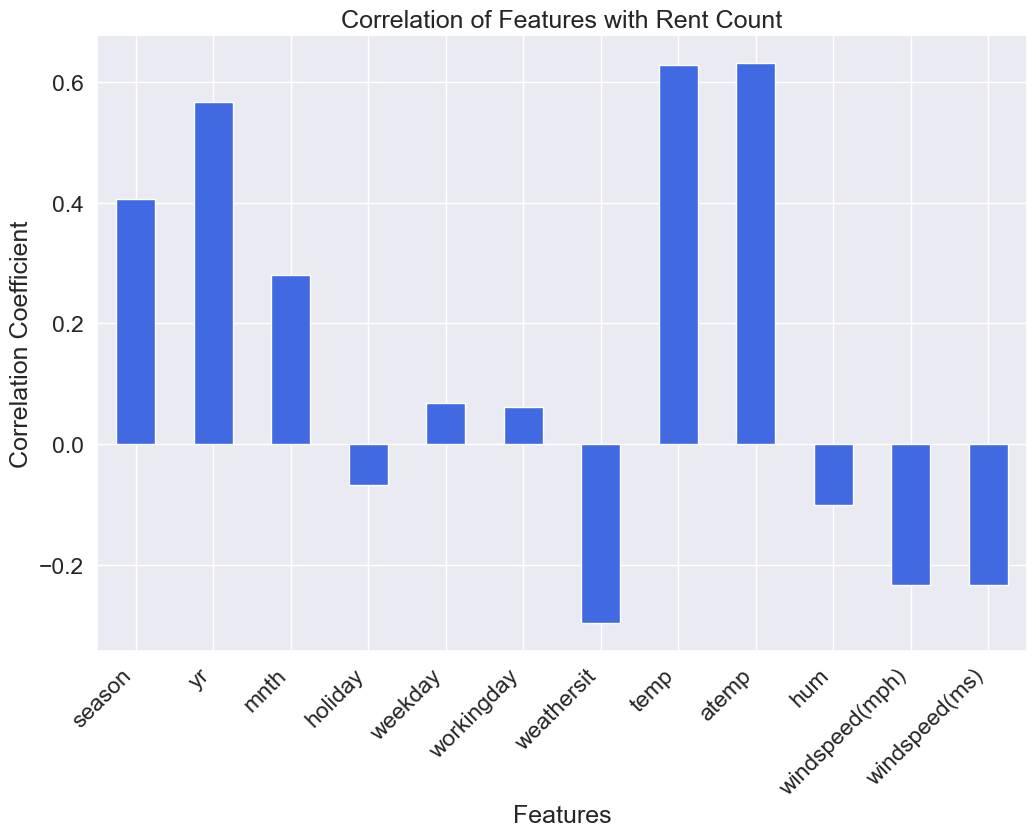

In [527]:
correlation_matrix = df.corr()
correlation_with_cnt = df.corrwith(df['cnt'])

print(f'Matrix correlation:\n{correlation_matrix}\n')

sns.set(font_scale=1.5)
plt.subplots(figsize = (20, 10))
sns.heatmap(correlation_matrix, square=True, annot=True, fmt='.2f', linewidths=.5, cmap='BuGn')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix Heatmap')

print(f'Correlation with Rent count:\n{correlation_with_cnt}')

plt.figure(figsize=(12, 8))
correlation_with_cnt[:-1].plot(kind='bar', color='royalblue')
plt.title('Correlation of Features with Rent Count')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(True)
plt.show()

Istnieją cechy w próbce, które korelują z cechą docelową, co oznacza, że problem można rozwiązać za pomocą metod liniowych.

Z wykresów widzimy, że niektóre cechy są do siebie podobne. Obliczmy więc również korelacje między rzeczywistymi atrybutami.

## Zadanie 3

Oblicz korelacje parami między cechami temp, atemp, hum, windspeed(mph), windspeed(ms) i cnt
przy użyciu metody corr:

Pairwise correlation:
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  



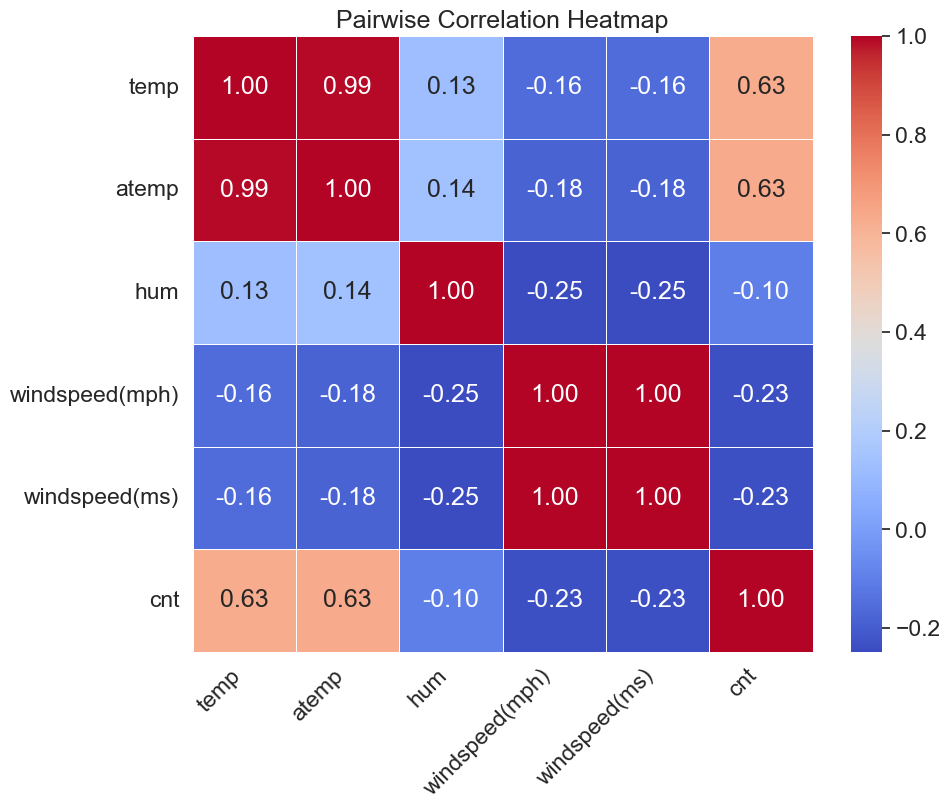

In [528]:
dual_df = df[['temp', 'atemp', 'hum', 'windspeed(mph)', 'windspeed(ms)', 'cnt']]
pair_correlation = dual_df.corr()
print(f'Pairwise correlation:\n{pair_correlation}\n')

sns.set(font_scale=1.5)
plt.figure(figsize=(10, 8))
sns.heatmap(pair_correlation, annot=True, fmt='.2f', linewidths=.5, cmap='coolwarm')
plt.title('Pairwise Correlation Heatmap')
plt.xticks(rotation=45, ha='right')
plt.show()

Na przekątnych, tak jak powinno być, znajdują się jednostki. Jednak w macierzy znajdują się jeszcze dwie pary silnie skorelowanych kolumn: temp i atemp (skorelowane z natury) oraz dwie prędkości wiatru (ponieważ jest to tylko tłumaczenie niektórych jednostek na inne). Dalej zobaczymy, że fakt ten negatywnie wpływa na uczenie modelu liniowego.

Na koniec przyjrzyjmy się średniej cech (metoda średniej), aby oszacować skalę cech i ułamek 1 w cechach binarnych.

## Zadanie 4

Wyznacz średnią cech

In [529]:
mean_values = df.mean()

print(f'Mean values of selected features:\n{mean_values}\n')

Mean values of selected features:
season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64



Atrybuty mają różne skale, więc do dalszej pracy lepiej znormalizujemy macierz obiekt-atrybut.

### Problem pierwszy: cechy współliniowe

Tak więc w naszych danych jedna cecha duplikuje inną cechę i istnieją jeszcze dwie bardzo podobne cechy. Oczywiście moglibyśmy od razu usunąć duplikaty, ale zobaczmy, jak wyglądałby trening modelu, gdybyśmy nie zauważyli tego problemu.

Po pierwsze, wykonajmy skalowanie lub standaryzację cech: od każdej cechy odejmiemy jej średnią i podzielimy ją przez jej odchylenie standardowe. Można to zrobić za pomocą metody skalowania.

Ponadto musimy wymieszać próbkę do walidacji krzyżowej.

In [530]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [531]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Przetrenujmy regresję liniową na naszych danych i przyjrzyjmy się wagom cech.

In [532]:
from sklearn.linear_model import LinearRegression

## Zadanie 5

Utwórz obiekt regresora liniowego, wytrenuj go na wszystkich danych i wyprowadź wagi modelu (wagi są przechowywane w zmiennej `coef_` klasy regresora). Możesz wyprowadzić pary (nazwa funkcji, waga) za pomocą funkcji `zip` wbudowanej w język Python. Nazwy cech są przechowywane w zmiennej `df.columns`.


In [533]:
columns = df.columns[:-1]
X_learn = df[columns]
y_learn = df['cnt']

regressor = LinearRegression()

regressor.fit(X_learn, y_learn)
weights = regressor.coef_

feature_names = x_columns.columns
weights_pairs = zip(feature_names, weights)

print('Feature weights:')
for feature, weight in weights_pairs:
    print(f'{feature}: {weight}')    

Feature weights:
season: 514.2755144217309
yr: 2043.9358557550588
mnth: -40.96296224733487
holiday: -519.3879461125579
weekday: 68.49550444316866
workingday: 121.29150193414044
weathersit: -606.453249792301
temp: 48.99538908049351
atemp: 71.91493309746625
hum: -10.23058594991835
windspeed(mph): 2401064826724.129
windspeed(ms): -5371182017466.677


Widzimy, że wagi dla cech zależnych liniowo są modulo znacznie większe niż dla innych cech. Aby zrozumieć, dlaczego tak się dzieje, przypomnijmy wzór analityczny używany do obliczania wag modelu liniowego w metodzie najmniejszych kwadratów:

$$w = (X^TX)^{-1} X^T y$$.

Jeśli $X$ ma współliniowe (liniowo zależne) kolumny, macierz $X^TX$ staje się zdegenerowana, a wzór nie jest już poprawny. Im bardziej zależne są cechy, tym mniejszy jest wyznacznik tej macierzy i tym gorsze przybliżenie $Xw \approx y$. Sytuacja ta nazywana jest _problemem wieloliniowości_.

Nie stało się tak w przypadku pary (temp, atemp) nieco mniej skorelowanych zmiennych, ale w praktyce zawsze warto uważnie obserwować współczynniki pod kątem podobnych znaków.

Aby rozwiązać problem wieloliniowości, musimy użyć regularyzatora. Do optymalizowanej funkcji dodaje się $L_1$ lub $L_2$ normę wag pomnożoną przez współczynnik regularyzacji $\alpha$. W pierwszym przypadku metoda nazywana jest Lasso, a w drugim --- Ridge

### Zadanie 6
Spróbujmy wytrenować modele liniowe z regularyzacją $L_1$ i $L_2$, a następnie porównajmy ich wagi. Wytrenuj regresory Ridge i Lasso z domyślnymi parametrami i zobacz, że problem z wagami został rozwiązany.

In [534]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_learn, y_learn, test_size=0.2, random_state=42)

Wytrenować model liniowy z $L_1$-regularizacją (klasa Lasso) i wyprowadzić wagi

In [535]:
lasso = Lasso()
lasso.fit(X_train, y_train)
lasso_weights = lasso.coef_

print("Lasso weights:")
for feature, weight in zip(X_learn.columns, lasso_weights):
    print(f"{feature}: {weight}")

Lasso weights:
season: 521.4291589449327
yr: 2019.4208593014257
mnth: -37.51215021080504
holiday: -353.60415907053414
weekday: 72.90465307734695
workingday: 158.63060194263434
weathersit: -626.6085142119675
temp: 52.786956006674394
atemp: 68.44195311072238
hum: -8.819719297045474
windspeed(mph): -31.188257928481242
windspeed(ms): -0.0


Wytrenować model liniowy z $L_2$-regularizacją (klasa Ridge) i wyprowadzić wagi

In [536]:
ridge = Ridge()
ridge.fit(X_train, y_train)
ridge_weights = ridge.coef_

print("Ridge weights:")
for feature, weight in zip(X_learn.columns, ridge_weights):
    print(f"{feature}: {weight}")

Ridge weights:
season: 521.8876469697619
yr: 2009.5368914358933
mnth: -37.677895808911515
holiday: -366.26046071815466
weekday: 72.96703460704964
workingday: 160.74149027255842
weathersit: -625.6001139391069
temp: 51.059476913156985
atemp: 70.04614508799816
hum: -8.903396278748671
windspeed(mph): -26.01231573305821
windspeed(ms): -11.628214577588817


### Zadanie 7

W przeciwieństwie do regularyzacji $L_2$, $L_1$ zeruje wagi dla niektórych cech. Zaobserwujmy, jak zmieniają się wagi wraz ze wzrostem współczynnika regularyzacji $\alpha$.

Dla każdej wartości współczynnika z `alphas`, wytrenuj regresor `Lasso` i zapisz wagi do listy `coefs_lasso`, a następnie wytrenuj `Ridge` i zapisz wagi do listy `coefs_ridge`. Przekonwertuj wynikowe listy na `np.array`.

In [537]:
alphas = np.arange(1, 500, 50)

coefs_lasso = []
coefs_ridge = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, y_train)
    coefs_lasso.append(lasso.coef_)
    
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    coefs_ridge.append(ridge.coef_)

coefs_lasso = np.array(coefs_lasso)
coefs_ridge = np.array(coefs_ridge)

print("Lasso coefficients for each alpha:")
print(coefs_lasso)
print("\nRidge coefficients for each alpha:")
print(coefs_ridge)

Lasso coefficients for each alpha:
[[ 521.42915894 2019.4208593   -37.51215021 -353.60415907   72.90465308
   158.63060194 -626.60851421   52.78695601   68.44195311   -8.8197193
   -31.18825793   -0.        ]
 [ 375.75775212 1795.78891384    0.           -0.           60.27092975
     0.         -319.53694592   49.29456639   79.12981499  -17.11353617
   -35.850612     -0.        ]
 [ 285.55362691 1578.26811868   16.90358432   -0.           42.99073399
     0.          -33.00036606   44.26196772   89.38733159  -24.7908111
   -40.70146471   -0.        ]
 [ 164.99573708 1370.55925364   44.7831851    -0.           29.45698204
     0.           -0.           41.14054173   95.21328184  -26.09964494
   -40.55202682   -0.        ]
 [  44.79207654 1164.35875567   72.4732331    -0.           16.46635487
     0.           -0.           37.05178911  101.53492215  -26.56032776
   -39.7259125    -0.        ]
 [   0.          960.81587849   80.52326953   -0.            3.71717629
     0.           -0

Przeanalizuj dynamikę wag w miarę zwiększania parametru regularyzacji:

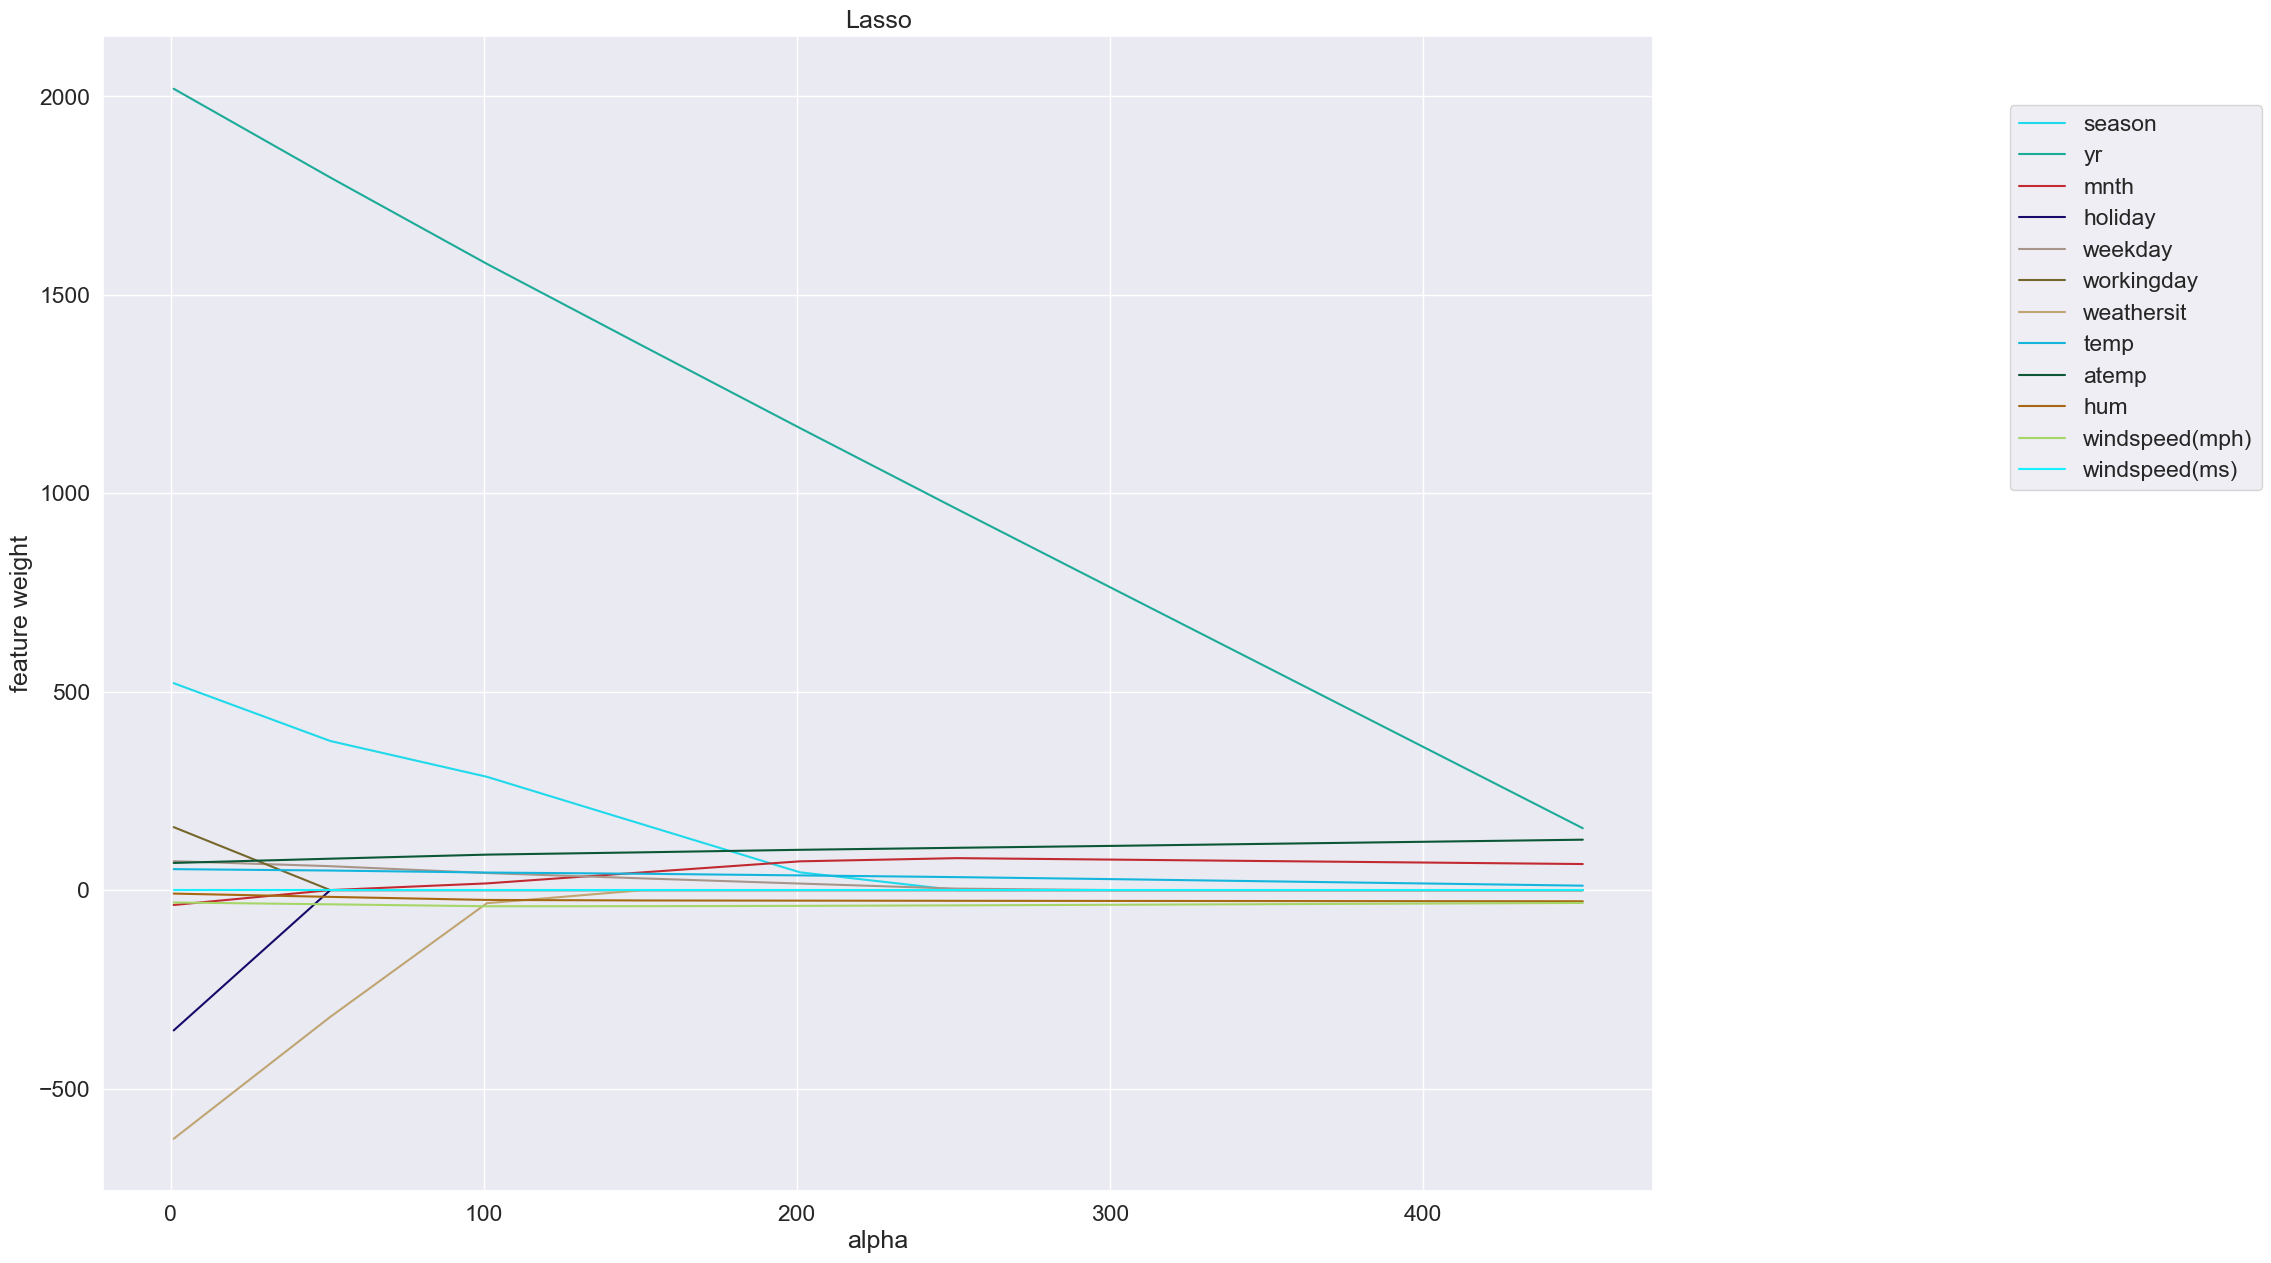

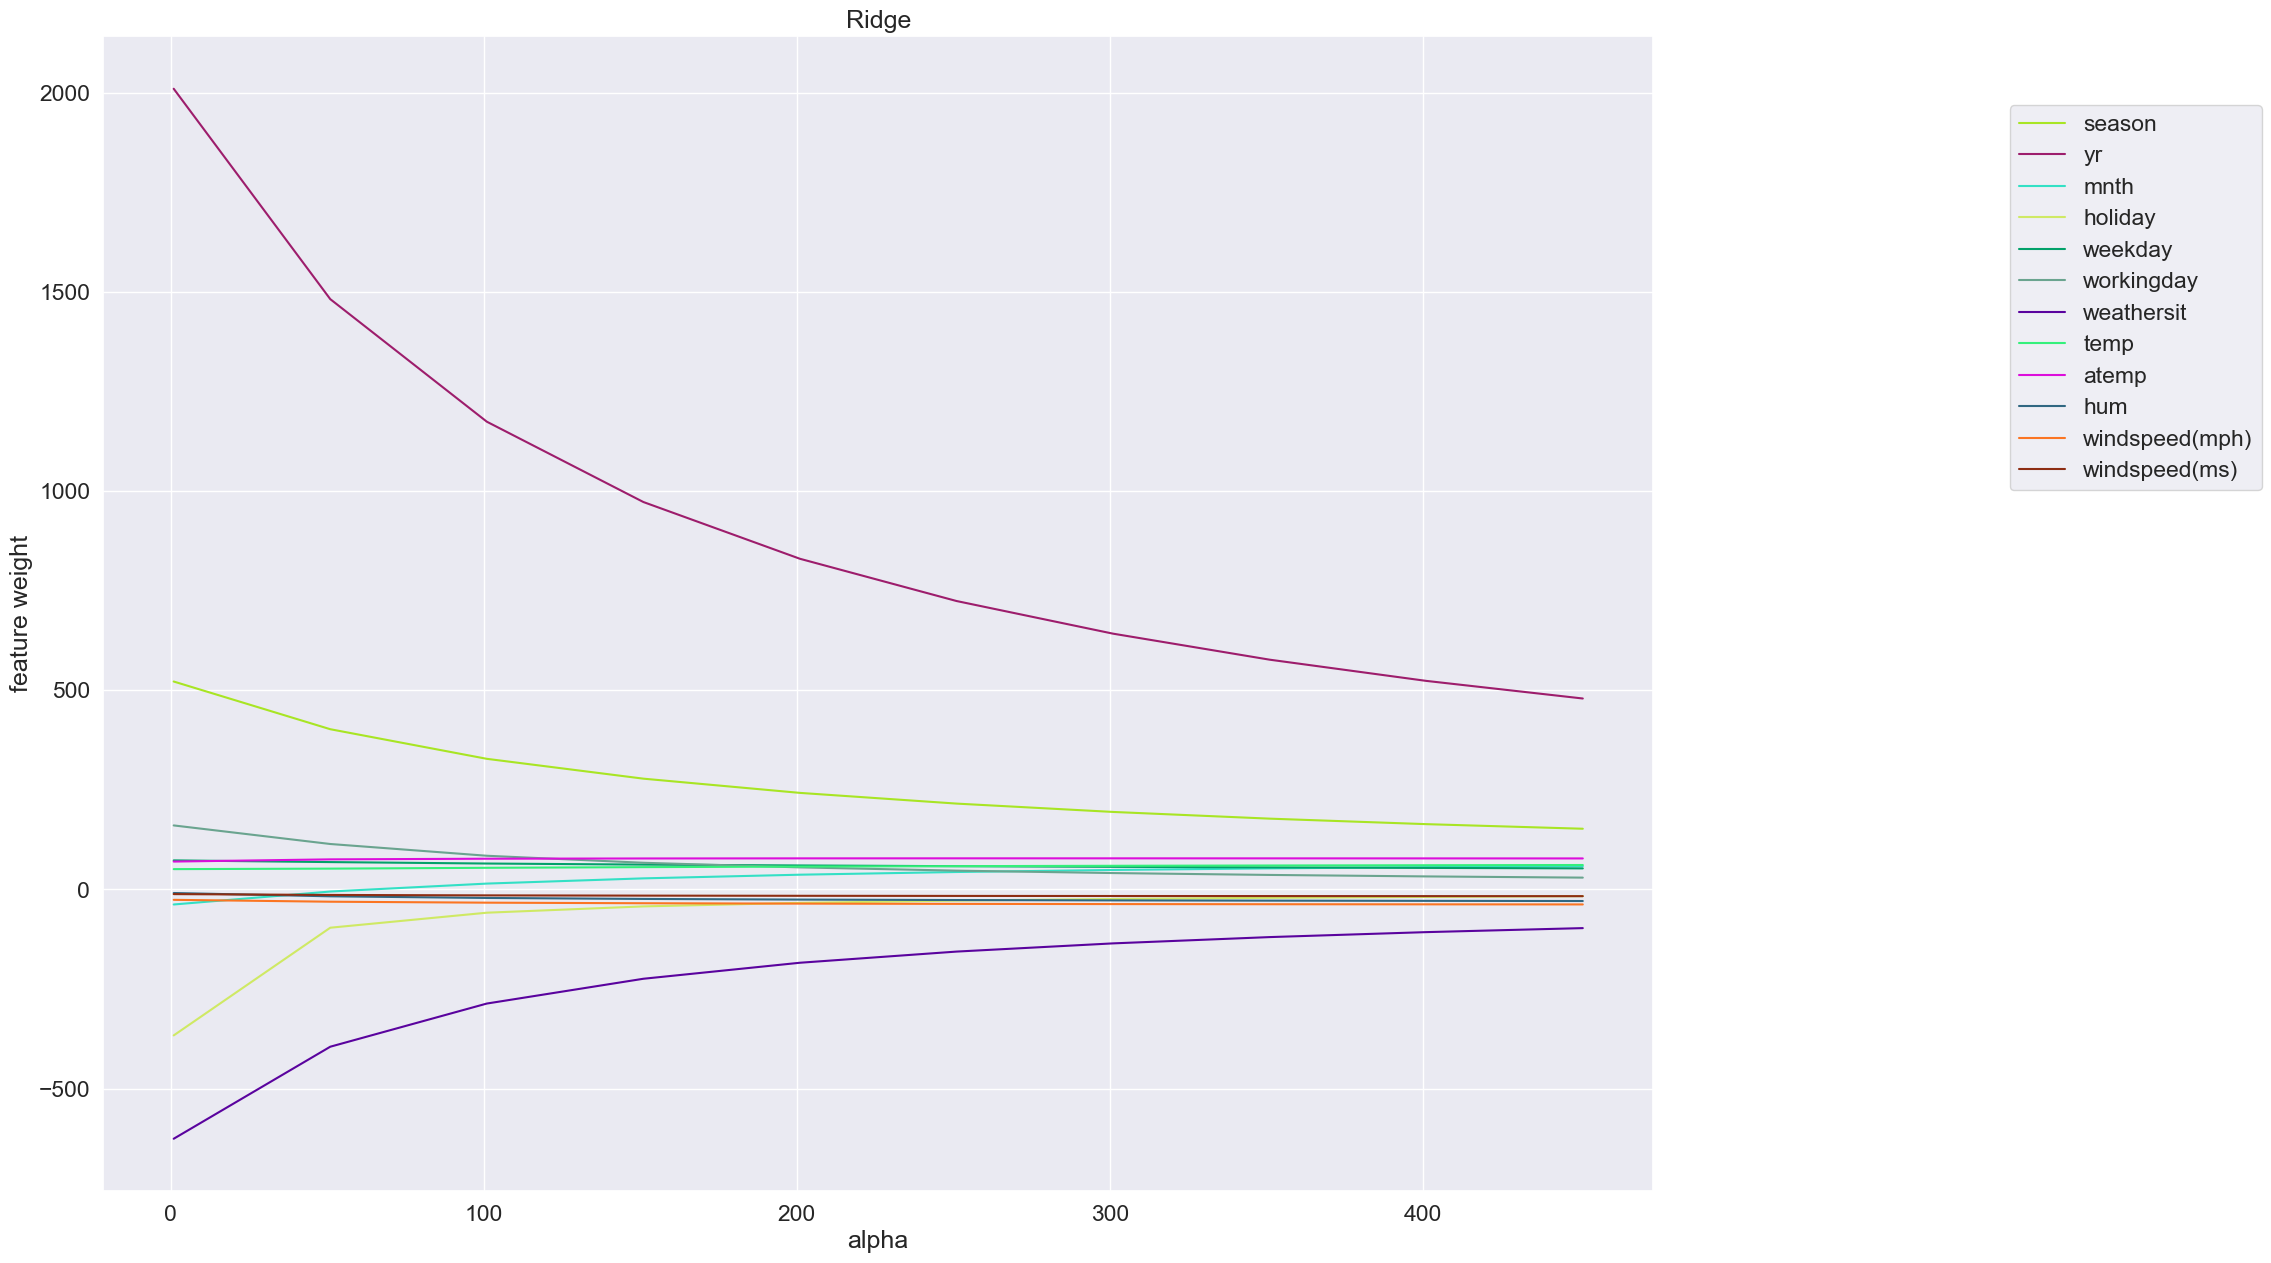

In [538]:
plt.figure(figsize=(20, 15))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(20, 15))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Przeanalizuj wykresy i odpowiedz na poniższe pytania.

1. Który regularyzator (Ridge czy Lasso) bardziej agresywnie redukuje wagi dla tej samej wartości alfa?
2. Co dzieje się z wagami Lasso, jeśli wartość alfa jest bardzo duża? Wyjaśnij, dlaczego tak się dzieje.
3. Czy można argumentować, że `Lasso` eliminuje jedną z cech `prędkość wiatru` dla dowolnej wartości `alfa > 0`? A Ridge? Mówi się, że regularyzator wyklucza cechę, jeśli współczynnik dla niej jest mniejszy niż $10^{-3}$.
4. Który regularyzator jest odpowiedni do wybierania nieinformatywnych cech?

In [539]:
# 1. Lasso.
# 2. All feature weights will become zero. This happens because Lasso imposes a penalty on the sum of the absolute values of the coefficients.
# 3. Lasso quickly decrease and become equal to zero. Ridge coefficients remain non-zero, although they can be very small.
# 4. Lasso is the best choice for selecting uninformative features due to its ability to reset feature weights to zero.

### Zadanie 8

Następnie będziemy pracować z `Lasso'.

Widzimy więc, że gdy zmieniamy alfa, model inaczej dopasowuje współczynniki cech. Musimy wybrać najlepszą wartość alfa.

W tym celu potrzebujemy przede wszystkim metryki jakości. Jako metryki użyjemy samej zoptymalizowanej funkcji najmniejszych kwadratów, tj. błędu średniokwadratowego.

Po drugie, musimy zrozumieć, na jakich danych obliczyć tę metrykę. Nie możemy wybrać "alfa" na podstawie wartości MSE na próbce treningowej, ponieważ wtedy nie możemy ocenić, w jaki sposób model będzie przewidywał na nowych danych. Jeśli wybierzemy jedną próbkę podzieloną między próbkę treningową i testową (nazywa się to wstrzymaniem), dostroimy się do konkretnych "nowych" danych i możemy ponownie przetrenować. Dlatego wykonamy kilka podziałów próbek, wypróbujemy różne wartości alfa dla każdej z nich, a następnie uśrednimy MSE. Wygodniej jest dokonać takich podziałów za pomocą walidacji krzyżowej, tj. podzielić próbkę na części $K$ i za każdym razem wziąć jedną z nich jako testową, a z pozostałych bloków utworzyć próbkę szkoleniową.

Przeprowadzenie walidacji krzyżowej dla regresji w sklearn jest dość proste: istnieje specjalny regresor do tego celu, __LassoCV__, który pobiera jako dane wejściowe listę alfa i dla każdego z nich oblicza MSE na walidacji krzyżowej. Po treningu (jeśli pozostawimy domyślny parametr cv=3), regresor będzie zawierał zmienną __mse\_path\___, macierz o rozmiarze len(alpha) x k, k = 3 (liczba bloków w walidacji krzyżowej), zawierającą wartości MSE na teście dla odpowiednich przebiegów. Ponadto zmienna alpha\_ będzie przechowywać wybraną wartość parametru regularyzacji, a coef\_ będzie tradycyjnie przechowywać wytrenowane wagi odpowiadające tej alpha_.

Należy pamiętać, że regresor może zmienić kolejność, w jakiej działa na alphas; lepiej jest użyć zmiennej regresora alphas_, aby dopasować ją do macierzy MSE.

Wytrenuj regresor `LassoCV` na wszystkich parametrach regularyzacji od alfa. Wykreśl linie _averaged_ over `MSE` jako funkcję `alpha` (w tym celu użyj funkcji `create_plot`).

Wyprowadź wybraną wartość `alpha`, jak również pary cecha-współczynnik dla wytrenowanego wektora współczynników.

In [540]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = list(map(lambda e: e[0], data))
    y = list(map(lambda e: e[1], data))
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()

Selected alpha: 11

Feature coefficients:
season: 487.8011412443858
yr: 1974.0456208995106
mnth: -27.952705445862104
holiday: -0.0
weekday: 72.76953426849926
workingday: 135.46818897591152
weathersit: -563.3815391114738
temp: 52.63620317317781
atemp: 70.37841557573266
hum: -10.541326447824627
windspeed(mph): -31.958866353392036
windspeed(ms): -0.0


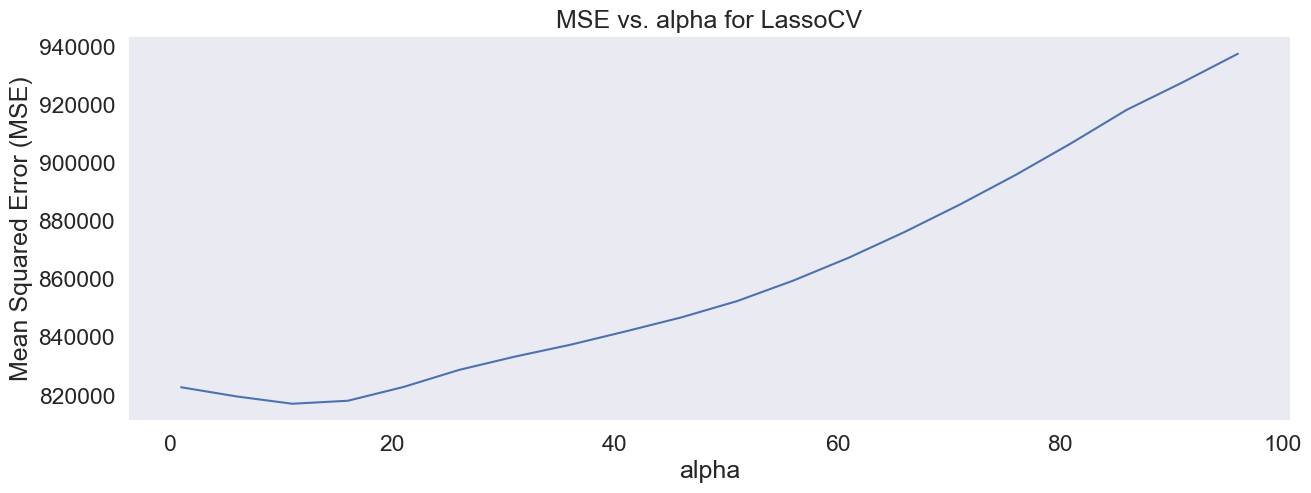

In [541]:
alphas = np.arange(1, 100, 5)

regressor = LassoCV(alphas=alphas, cv=5, random_state=42)
regressor.fit(X_train, y_train)

mse_path = np.mean(regressor.mse_path_, axis=1)

data_for_plot = list(zip(regressor.alphas_, mse_path))

best_alpha = regressor.alpha_
print(f"Selected alpha: {best_alpha}\n")

lasso_coefficients = regressor.coef_
print("Feature coefficients:")
for feature, coefficient in zip(x_columns, lasso_coefficients):
    print(f"{feature}: {coefficient}")
    
create_plot(data_for_plot, "MSE vs. alpha for LassoCV", "alpha", "Mean Squared Error (MSE)")

Wybraliśmy więc pewien parametr regularyzacji. Zobaczmy, jaki parametr alfa wybralibyśmy, gdybyśmy podzielili próbkę tylko raz na trening i test, tj. rozważyli trajektorie MSE odpowiadające oddzielnym blokom próbki.

### Zadanie 9

Wyprowadź wartości `alpha` odpowiadające minimom `MSE` na każdej partycji (tj. według kolumn).
Wizualizacja kolumn `mse_path_` na trzech oddzielnych wykresach.


In [542]:
min_mse_alphas = regressor.alphas_[np.argmin(regressor.mse_path_, axis=0)]
min_mse_values = np.min(regressor.mse_path_, axis=0)
print("\nAlphas with minimum MSE:")
for i, (alpha, mse) in enumerate(zip(min_mse_alphas, min_mse_values)):
    print(f"Alpha = {alpha}, MSE = {mse}")


Alphas with minimum MSE:
Alpha = 16, MSE = 824563.8393918031
Alpha = 6, MSE = 657939.3081986657
Alpha = 16, MSE = 930989.9733219288
Alpha = 26, MSE = 1045748.309882626
Alpha = 1, MSE = 603993.8038656304


W każdej partycji optymalna wartość "alfa" jest inna i odpowiada dużemu MSE w innych partycjach. Okazuje się, że dostosowujemy się do konkretnych próbek treningowych i kontrolnych. Kiedy wybieramy `alpha` w walidacji krzyżowej, wybieramy coś "średniego", co da akceptowalną wartość metryki na różnych partycjach próbki.

### Zadanie 10

Na koniec, jak to zwykle bywa w analizie danych, zinterpretujmy wynik. Odpowiedz na następujące pytania.

#### Pytanie 1

W ostatnim wytrenowanym modelu wybierz 4 cechy o najwyższych (dodatnich) współczynnikach (i wypisz je), spójrz na wizualizacje zależności `cnt` od tych cech, które narysowaliśmy w bloku "Poznawanie danych". Czy na wykresach widać rosnącą liniową zależność `cnt` od tych cech? Czy logiczne jest twierdzenie (wynikające ze zdrowego rozsądku), że im większa wartość tych atrybutów, tym więcej osób będzie chciało wypożyczyć rowery?

__Odpowiedź:__

In [543]:
# The attributes temp, atemp, yr and season have the largest positive coefficients in the model
# and show an increasing linear relationship with the number of bicycle rentals,
# which is logical from the point of view of common sense.

#### Pytanie 2

Wybierz 3 cechy o największych współczynnikach modulo ujemnych (i wypisz je), spójrz na odpowiednie wizualizacje. Czy widoczna jest malejąca zależność liniowa? Czy logiczne jest stwierdzenie, że im większa wielkość tych cech, tym mniej osób będzie chciało wsiąść na rower?

__Odpowiedź:__

In [544]:
# The attributes weathersit, hum and windspeed(mph) have the largest negative coefficients in the model
# and show a decreasing linear relationship with the number of bicycle rentals.

#### Pytanie 3

Wypisz znaki ze współczynnikami bliskimi zeru (< 1e-3). Jak myślisz, dlaczego model wykluczył je z modelu (spójrz ponownie na wykresy)? Czy to prawda, że nie mają one wpływu na popyt na rowery?

__Odpowiedź:__

In [545]:
# The attributes holiday, weekday, workingday and windspeed(ms) have coefficients close to zero.
# The model excluded them because they do not have a significant impact on the demand for bicycles.

### Wnioski
Widzieliśmy więc, jak monitorować adekwatność modelu liniowego, jak wybierać cechy i jak prawidłowo wybrać współczynnik regularyzacji, jeśli to możliwe bez dostosowywania się do określonej części danych.

Warto zauważyć, że wygodnie jest wybrać tylko niewielką liczbę parametrów (1, 2, maksymalnie 3) za pomocą walidacji krzyżowej, ponieważ dla każdej dopuszczalnej kombinacji parametrów musimy trenować model kilka razy. Proces ten zajmuje dużo czasu, zwłaszcza jeśli musimy trenować na dużych ilościach danych.